In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
import tensorboard
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def imgshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

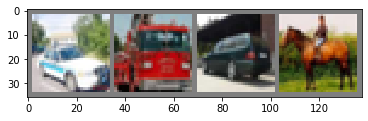

  car truck   car horse


In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)
imgshow(img_grid)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_image('four_cifar10_images', img_grid)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

class Net(pl.LightningModule):
    def __init__(self, hparams, input_size=3 * 32 * 32, num_classes=10):
        super().__init__()
        self.hparams = hparams
        
        self.model = nn.Sequential(
            nn.Linear(input_size, self.hparams["1_hidden"]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hparams["1_hidden"], self.hparams["2_hidden"]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hparams["2_hidden"], self.hparams["3_hidden"]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hparams["3_hidden"], self.hparams["4_hidden"]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hparams["4_hidden"], self.hparams["5_hidden"]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hparams["5_hidden"], self.hparams["6_hidden"]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hparams["6_hidden"], num_classes),
        )
        
    def forward(self, x):
        N, _, _, _ = x.shape # flatten the image first
        x = x.view(N, -1)
        x = self.model(x)
        return x
    
    def general_step(self, batch, batch_idx, mode):
        images, targets = batch
        
        #forward pass
        out = self.forward(images)
        
        # loss
        loss = F.cross_entropy(out, targets)
        
        preds = out.argmax(axis=1)
        n_correct = (targets == preds).sum()
        return loss, n_correct
    
    def general_end(self, outputs, mode):
        # average over all batches aggregated during one epoch
        avg_loss = torch.stack([x[mode + '_loss'] for x in outputs]).mean()
        total_correct = torch.stack([x[mode + '_n_correct'] for x in outputs]).sum().cpu().numpy()
        acc = total_correct / len(self.dataset[mode])
        return avg_loss, acc

    
    def training_step(self, batch, batch_idx):
        loss, n_correct = self.general_step(batch, batch_idx, "train")
        # logs 
        tensorboard_logs = {'loss': loss}
        return {'loss': loss, 'train_n_correct': n_correct, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        loss, n_correct = self.general_step(batch, batch_idx, "test")
        return {'val_loss': loss, 'val_n_correct': n_correct}
        
    def test_step(self, batch, batch_idx):
        loss, n_correct = self.general_step(batch, batch_idx, "test")
        return {'test_loss': loss, 'test_n_correct': n_correct}
    
    def validation_end(self, outputs):
        avg_loss, acc = self.general_end(outputs, "val")
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'val_acc': acc, 'log': tensorboard_logs}
        
    def prepare_data(self):
        mean=[0.485, 0.456, 0.406]
        std=[0.229, 0.224, 0.225]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std, inplace=False)])
        
        cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        
        # train/val split
        train_dataset, val_dataset = random_split(cifar10_train, [40000, 10000])
            
        self.dataset = {}
        self.dataset["train"], self.dataset["val"], self.dataset["test"] = train_dataset, val_dataset, cifar10_test
    
    @pl.data_loader
    def train_dataloader(self):
        return DataLoader(self.dataset["train"], shuffle=True, batch_size=self.hparams["batch_size"])
    
    @pl.data_loader
    def val_dataloader(self):
        return DataLoader(self.dataset["val"], batch_size=self.hparams["batch_size"])
    
    @pl.data_loader
    def test_dataloader(self):
        return DataLoader(self.dataset["test"], batch_size=self.hparams["batch_size"])
    
    def configure_optimizers(self):
        opt = torch.optim.SGD(self.model.parameters(), lr=self.hparams['learning_rate'], momentum=0.9)
        return opt
        
    def visualize_predictions(self, images, preds, targets):
        classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        imgs = images
        # determine size of the grid based on batch size
        num_rows = torch.tensor(len(images)).float().sqrt().floor()
        
        fig = plt.figure(figsize=(10, 10))

        for i in range(len(imgs)):
            plt.subplot(num_rows, len(imgs) // num_rows + 1, i+1)
            img = imgs[i].cpu()
            img = img / 2 + 0.5
            npimg = img.numpy()
            plt.imshow(np.transpose(npimg, (1, 2, 0)))
            plt.title(classes[torch.argmax(preds, axis=-1)[i]] + f'\n[{classes[targets[i]]}]')
            plt.axis('off')
            
        self.logger.experiment.add_figure('predictions', fig, global_step=self.global_step)
        
    def get_test_acc(self, loader = None):
        self.model.eval()
        self.model = self.model.cuda()
        
        if not loader: loader = self.test.data_loader()
        
        scores = []
        labels = []
        
        for batch in loader:
            X, y = batch
            X = X.cuda()
            score = self.forward(X)
            scores.append(score.detach().cpu().numpy())
            labels.append(y.detach().cpu().numpy())
            
        scores = np.concatenate(scores, axis=0)
        labels = np.concatenate(labels, axis=0)
        
        preds = scores.argmax(axis=1)
        acc = (labels == preds).mean()
        return preds, acc

In [18]:
hparams = {
    "1_hidden": 2048,
    "2_hidden": 1024,
    "3_hidden": 512,
    "4_hidden": 256,
    "5_hidden": 128,
    "6_hidden": 64,
    "batch_size": 64,
    "learning_rate": 1e-3,
}

In [19]:
model = Net(hparams)

trainer = pl.Trainer(
    profiler=True,
    max_epochs=75,
    gpus=1
)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


In [20]:
trainer.fit(model)

Files already downloaded and verified
Files already downloaded and verified



   | Name     | Type       | Params
------------------------------------
0  | model    | Sequential | 9 M   
1  | model.0  | Linear     | 6 M   
2  | model.1  | ReLU       | 0     
3  | model.2  | Dropout    | 0     
4  | model.3  | Linear     | 2 M   
5  | model.4  | ReLU       | 0     
6  | model.5  | Dropout    | 0     
7  | model.6  | Linear     | 524 K 
8  | model.7  | ReLU       | 0     
9  | model.8  | Dropout    | 0     
10 | model.9  | Linear     | 131 K 
11 | model.10 | ReLU       | 0     
12 | model.11 | Dropout    | 0     
13 | model.12 | Linear     | 32 K  
14 | model.13 | ReLU       | 0     
15 | model.14 | Dropout    | 0     
16 | model.15 | Linear     | 8 K   
17 | model.16 | ReLU       | 0     
18 | model.17 | Dropout    | 0     
19 | model.18 | Linear     | 650   




Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.016          	|  0.016          
on_epoch_start      	|  0.00292        	|  0.219          
get_train_batch     	|  0.015061       	|  707.11         
on_batch_start      	|  2.2955e-05     	|  1.076          
model_forward       	|  0.0033683      	|  157.89         
model_backward      	|  0.0038068      	|  178.44         
on_after_backward   	|  3.968e-06      	|  0.186          
optimizer_step      	|  0.002694       	|  126.28         
on_batch_end        	|  0.0016042      	|  75.198         
on_epoch_end        	|  0.00021333     	|  0.016          
on_train_end        	|  0.0            	|  0.0            



1

In [21]:
_, acc = model.get_test_acc(model.val_dataloader())
print("Test-Accuracy: {}%".format(acc*100))

Test-Accuracy: 54.52%
